# 地理加权回归

本笔记本演示了如何使用 Oshan 等人中包含的示例代码使用 MGWR Python 包执行地理加权回归
Oshan et al. 2019. MGWR: A Python Implementation of Multiscale Geographically Weighted Regression for Investigating Process Spatial Heterogeneity and Scale. *ISPRS Int. J. Geo-Inf.* 2019, 8(6), 269; https://doi.org/10.3390/ijgi8060269.

GWR（Geographically Weighted Regression）是一种空间数据分析方法，用于处理空间异质性（spatial heterogeneity）问题。与传统的全局回归方法不同，GWR考虑了空间上相邻观测点之间的关联性，允许回归系数在空间上发生变化。这意味着，GWR可以捕捉到在空间上不同地区（或位置）的变量之间关系的差异。

在GWR中，回归系数不再是全局的，而是在每个观测点附近局部生成的。这种方法对于那些在不同地理位置或空间单元内有不同影响因素的研究非常有用。GWR通常用于地理信息系统（GIS）和地理统计学中，用于研究空间数据的空间相关性和空间预测。

GWR的基本思想是，每个观测点的响应变量与邻近点的观测值相关，但关系的强度和方向可以因地理位置的不同而异。GWR模型的结果包括每个观测点附近的局部回归系数，这些系数在空间上的分布可以用来理解变量之间的空间异质性。

## 内容
- [安装 MGWR Python 包](#install_mgwr)
- [导入所需的包](#import)
- [加载和预览数据](#load_data)
- [GWR 数据预处理](#preprocess)
- [设置 GWR 带宽](#set_bw)
- [适合 GWR 模型](#fit_model)
- [绘制带宽变化](#plot_bdw)
- [评估并绘制模型拟合](#assess_fit)

<a id="install_mgwr"></a>
## 安装 MGWR Python 包

以下行将安装 MGWR Python 包（如果尚未安装）。 该包的文档可以在[此处](https://mgwr.readthedocs.io/en/latest/index.html)找到，地理加权回归部分的文档可以在[此处](https://mgwr .readthedocs.io/en/latest/ generated/mgwr.gwr.GWR.html#mgwr.gwr.GWR）。

In [1]:
try:
    from mgwr.gwr import GWR
except:
    print('Installing MGWR')
    ! pip install -U mgwr

d:\work\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="import"></a>
## 导入所需的包

运行示例代码需要这些包。

In [2]:
# code in this cell is from Oshan et al. 2019

import numpy as np
import pandas as pd
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

<a id="load_data"></a>
## 加载和预览数据

这里乔治亚州各县的数据是从示例数据集中加载的。 使用 matplotlib 映射基础数据。

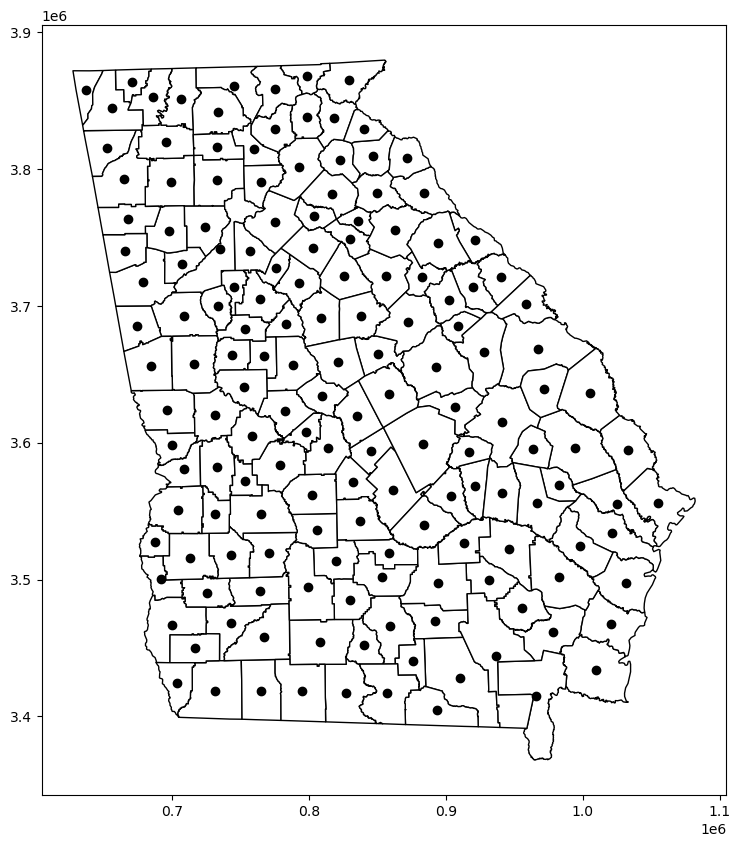

In [3]:
# import Georgia dataset and show counties
# code in this cell is from Oshan et al. 2019

georgia = gp.read_file(ps.examples.get_path('G_utm.shp'))
fig, ax = plt.subplots(figsize = (10, 10))
georgia.plot(ax=ax, **{'edgecolor': 'black', 'facecolor': 'white'})
georgia.centroid.plot(ax = ax, c = 'black')
plt.show()

### 加载和预览数据

在接下来的单元格中，说明了示例中使用的数据格式。

In [4]:
# inspect georgia data type

type(georgia)

geopandas.geodataframe.GeoDataFrame

In [5]:
# inspect base data structure

georgia.head()

,AREA,PERIMETER,G_UTM_,G_UTM_ID,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,PctFB,PctPov,PctBlack,X,Y,AreaKey,geometry
0,1.331370e+09,207205.0,132,133,31.75339,-82.28558,15744,75.6,8.2,11.43,0.64,19.9,20.76,941396.6,3521764,13001,"POLYGON ((931869.062 3545540.500, 934111.625 3..."
1,8.929300e+08,154640.0,157,158,31.29486,-82.87474,6213,100.0,6.4,11.77,1.58,26.0,26.86,895553.0,3471916,13003,"POLYGON ((867016.312 3482416.000, 884309.375 3..."
2,7.434020e+08,130431.0,148,146,31.55678,-82.45115,9566,61.7,6.6,11.11,0.27,24.1,15.42,930946.4,3502787,13005,"POLYGON ((914656.875 3512190.000, 924718.375 3..."
3,9.053950e+08,185737.0,158,155,31.33084,-84.45401,3615,100.0,9.4,13.17,0.11,24.8,51.67,745398.6,3474765,13007,"POLYGON ((744258.625 3480598.500, 765025.062 3..."
4,6.941830e+08,151347.0,76,79,33.07193,-83.25085,39530,42.7,13.3,8.64,1.43,17.5,42.39,849431.3,3665553,13009,"POLYGON ((832974.188 3677273.500, 834048.688 3..."


In [6]:
# inspect centroids

georgia.centroid.head()

0    POINT (946421.511 3522063.064)
1    POINT (892248.432 3469655.794)
2    POINT (931804.516 3499689.285)
3    POINT (743153.933 3468328.184)
4    POINT (850194.951 3664941.794)
dtype: geometry

<a id="preprocess"></a>
## GWR 数据预处理

数据被转换为加载到 GWR 模型中的预期格式。

In [7]:
# process input data for GWR
# code in this cell is from Oshan et al. 2019

g_y = georgia['PctBach'].values.reshape((-1, 1))
g_X = georgia[['PctFB', 'PctBlack', 'PctRural']].values
u = georgia['X']
v = georgia['Y']
g_coords = list(zip(u, v))

### 查看处理数据的格式

In [8]:
# inspect data contents

print('g_y:\n', g_y[:5])
print('\ng_X:\n', g_X[:5])
print('\nu:\n', list(u[:5]))
print('\nv:\n', list(v[:5]))
print('\ng_coords:\n', g_coords[:5], "\n")

g_y:
 [[ 8.2]
 [ 6.4]
 [ 6.6]
 [ 9.4]
 [13.3]]

g_X:
 [[  0.64  20.76  75.6 ]
 [  1.58  26.86 100.  ]
 [  0.27  15.42  61.7 ]
 [  0.11  51.67 100.  ]
 [  1.43  42.39  42.7 ]]

u:
 [941396.6, 895553.0, 930946.4, 745398.6, 849431.3]

v:
 [3521764, 3471916, 3502787, 3474765, 3665553]

g_coords:
 [(941396.6, 3521764), (895553.0, 3471916), (930946.4, 3502787), (745398.6, 3474765), (849431.3, 3665553)] 



<a id="set_bw"></a>
## 设置 GWR 带宽

这里模型带宽是通过计算确定的。

In [9]:
# select bandwidth computationally 
# code in this cell is from Oshan et al. 2019

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

d:\work\miniconda3\lib\site-packages\numba\core\dispatcher.py:241: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.3 (d:\work\miniconda3\lib\site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  entrypoints.init_all()


117.0


<a id="fit_model"></a>
## 适合 GWR 模型

此处构建模型并将其拟合到输入。

In [10]:
# fit the model 
# code in this cell is from Oshan et al. 2019

gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
gwr_results = gwr_model.fit()
print(gwr_results.resid_ss)

1650.8596982770296


<a id="plot_bdw"></a>
## 绘制带宽变化图

该模型使用不同的带宽进行了多次拟合，并绘制了差异图。

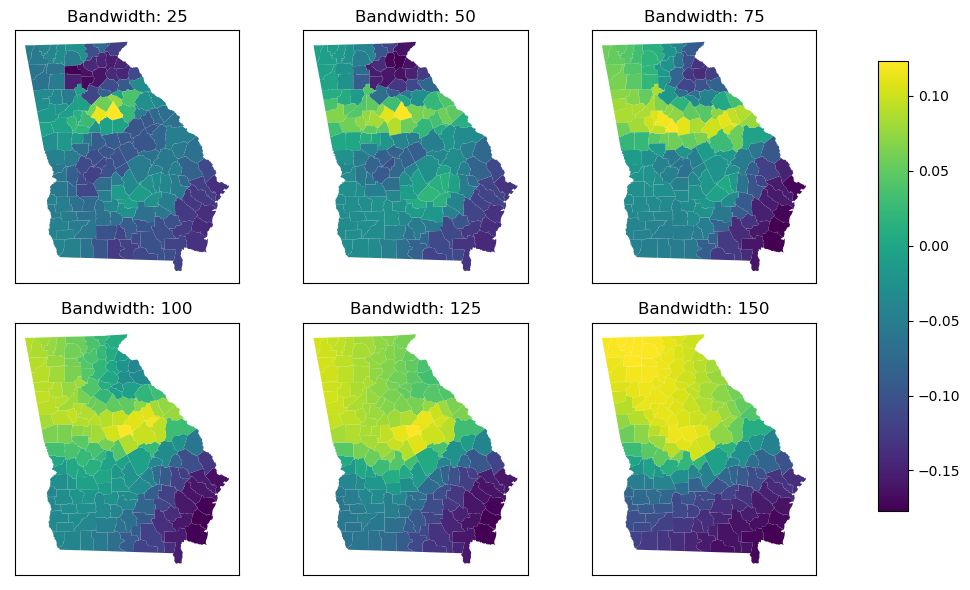

In [11]:
# visualize effects of changing bandwidth
# code in this cell is from Oshan et al. 2019

fig, ax = plt.subplots(2, 3, figsize = (10, 6))
bws = (x for x in range(25, 175, 25))
vmins = []
vmaxs = []
for row in range(2):
    for col in range(3):
        bw = next(bws)
        gwr_model = GWR(g_coords, g_y, g_X, bw)
        gwr_results = gwr_model.fit()
        georgia['rural'] = gwr_results.params[:, -1]
        georgia.plot('rural', ax = ax[row, col])
        ax[row,col].set_title('Bandwidth: ' + str(bw))
        ax[row,col].get_xaxis().set_visible(False)
        ax[row,col].get_yaxis().set_visible(False)
        vmins.append(georgia['rural'].min())
        vmaxs.append(georgia['rural'].max())
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min(vmins), vmax=max(vmaxs)))
fig.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.14, 0.03, 0.75])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.show()


<a id="assess_fit"></a>
## 评估和绘制模型拟合

最后，计算全局和局部拟合的度量。

In [12]:
# assess global model fit
# code in this cell is from Oshan et al. 2019

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)
gwr_results = gwr_model.fit()
print(gwr_results.aic)
print(gwr_results.aicc)
print(gwr_results.R2)

848.9154070534352
851.3502927844658
0.678074266959346


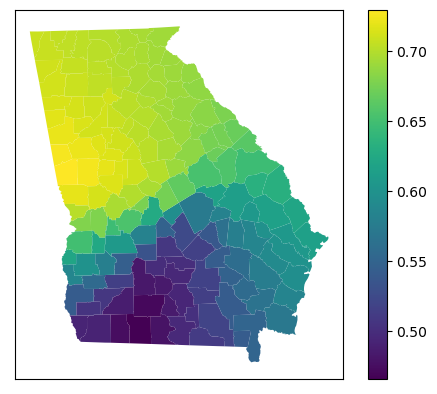

In [13]:
# assess local model fit
# code in this cell is from Oshan et al. 2019

georgia['R2'] = gwr_results.localR2
georgia.plot('R2', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()